# Converting Dark Channel Kernels into a TFRecord

This code stores the dark channel kernels as byte data on a TFRecord

## Connect to Google Cloud Storage (GCS)

The kernels are stored on a GCS bucket. Alternatively, they can be stored locally or on Google Drive 



In [ ]:
## IGNORE if storing kerenels locally or on Google Drive
#Authenticare access to cloud storage
!gcloud auth login

#Set current GCS project
!gcloud config set project superres000

In [2]:
## IGNORE if storing kerenels locally or on Google Drive
#Setup google cloud sdk (seems to be necessary but could be redudant)
from google.colab import auth
auth.authenticate_user()

## Import Libraries 

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np
import os, sys, math


## Config.

Given the small size of each kernel, they are all stored on one TF Record


In [44]:
# GCS Bucket containting kernels
GCS_PATTERN = 'gs://super_res_train/Images/*.png' 

# Bucket to save TFRecords
GCS_OUTPUT = 'gs://super_res_train/Kernels/Training/' 
nb_images = len(tf.io.gfile.glob(GCS_PATTERN))

# Number of TFRecords to create
SHARDS = 1
shard_size = math.ceil(1.0 * nb_images / SHARDS)

# Image Size
IMG_SHAPE = [25,25]
NUM_CHANNELS = 1

print('Number of Images {}'.format(nb_images))
print('Images/shard: {}'.format(shard_size))


Number of Images 1824
Images/shard: 1824


## Read Files and Add to a TF Dataset

In [45]:
# Read files
def decode_jpeg_and_label(filename):
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

# Add Files to the TF Dataset
AUTO = tf.data.experimental.AUTOTUNE 
filenames = tf.data.Dataset.list_files(GCS_PATTERN, seed=35155) # This also shuffles the images
dataset1 = filenames.map(decode_jpeg_and_label, num_parallel_calls=AUTO)
dataset1 = dataset1.batch(shard_size)

## Write dataset to a TF Record

In [46]:
# Writes TFDataset to a TF Record
def writeTFRecord(writer,image,label):
  example = tf.train.Example(features=tf.train.Features(feature={
        'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[label])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image]))
    }))
  writer.write(example.SerializeToString())
  return 

# Write files
for i,(img,label) in enumerate(dataset1):
  filename = GCS_OUTPUT + '{:02d}DCKernels.tfrec'.format(i)
  writer = tf.io.TFRecordWriter(filename)
  writeTFRecord(writer,img.numpy().tobytes(),label.numpy().tobytes())
  
  #For some reason the last TF Record is not saved - this is a quick fix
  if i+1 == SHARDS:
    writer = tf.io.TFRecordWriter(filename)
    writeTFRecord(writer,img.numpy().tobytes(),label.numpy().tobytes())
  print('Completed: {}/{} Wrote File: {}'.format(i+1,SHARDS,filename))


Completed: 1/1 Wrote File: gs://super_res_train/Kernels/Training/00DCKernels.tfrec


## Read the TFRecrods

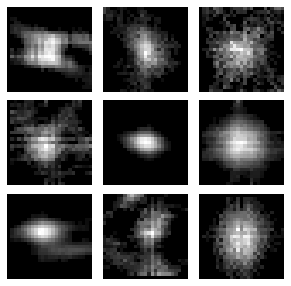

In [47]:
# Select TFRrecord to read
GCS_File = GCS_OUTPUT + '00DCKernels.tfrec'
dataset = tf.data.TFRecordDataset(GCS_File)



def read_tfrecord(example):
# Create a dictionary describing the features.
  features = {
      'image': tf.io.FixedLenFeature([], tf.string),
      'label': tf.io.FixedLenFeature([], tf.string)
  }
  
  example = tf.io.parse_single_example(example, features)

  image = tf.io.decode_raw(example['image'], 'uint8')
  image = tf.reshape(image, [nb_images,IMG_SHAPE[0],IMG_SHAPE[1], NUM_CHANNELS])
  
  # This is broken - however labels are unnecessary
  label  = example['label']

  return image, label

dataset = dataset.map(read_tfrecord)

for (image,label) in dataset:
  images = np.array(image)
  
  #Display first 9 images
  plt.figure(figsize=(5,5))
  subplot=331
  for i in range(9):
    img = tf.reshape(images[i,:,:,:],IMG_SHAPE)
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(img,cmap='gray')
    subplot += 1
    if i==8:
      break
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

   
   




